## Final Project Submission

Please fill out:
* Student name: Igor Kirko
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


## The Project Goal

For this project I had to chose a problem that can be solved by classification, find a appropriate dataset and build a classification model that solves my problem. 
The problem I chose is:

## **Is it possible to predict movie success or failure based on budget, genre, cast and crew information?**


Steps that I took to solve this problem:

- **Scraped information from boxofficemojo website and stored it in a Dataframe.** 
- **Calculated movie success by comparing budget and worldwide boxoffice.**
- **Cleaned and prepared data.**
- **Tested my dataset across multiple classifiers and picked the ones with best results.**
- **Performed gridsearch to identify best hyperparameters.**
- **Tested model against cast and crew from most profitable movies.**

## 1. Prepare workplace

### libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.style.use('seaborn')
current_palette = sns.color_palette('deep')
sns.palplot(current_palette)
plt.xkcd()
%matplotlib inline
from random import sample 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Functions

#### Clean and filter data

In [2]:
def hr_to_min(time):
    '''transforms time string to integer that showes total number of minutes.
       input: string in the format of %hr%min.
       return: total minutes in integer format.
       '''
    timelist = time.split()
    if len(timelist) > 2:
        return int(timelist[0]) * 60 + int(timelist[2])
    else:
        return int(timelist[0]) * 60

def date_to_month(date):
    '''Cuts day from a month/day date
    return: month'''
    datelist = date.split()
    return datelist[0]

In [3]:
def filter_by_freq(df, column, min_freq):
    """Filters the DataFrame based on the value frequency in the specified column.
    input: DataFrame, Column name, Minimal value frequency for the row to be accepted.
    return: Frequency filtered DataFrame.
    """
    # Frequencies of each value in the column.
    freq = df[column].value_counts()
    # Select frequent values. Value is in the index.
    frequent_values = freq[freq >= min_freq].index
    # Return only rows with value frequency above threshold.
    return df[df[column].isin(frequent_values)]

In [4]:
def clean_data(df, cols_to_drop):
    """Drops the unnecessary columns and fills None values of the DataFrame.
    return: cleaned DataFrame.
    """
    #drop unnecessary columns and rows
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.dropna(subset=['release_date', 'main_actor_2', 'composer', 'producer', 'distributor', 'run_time'], inplace=True)
   
    
    genres = ['genre_1', 'genre_2']
    df.dropna(subset=genres, inplace=True)
    
    #fill Null cinematographers with directors from the same movie
    fill_cin = df[df['cinematographer'].isnull()].director
    df.cinematographer.fillna(fill_cin, inplace=True)
    
    #fill mpaa with most common rating
    df.mpaa.fillna('PG-13', inplace=True)
    
    #fill budget with mean value
    df.budget.fillna(30000000, inplace=True)
    #transform run_time and date
    df['run_time'] = df['run_time'].apply(lambda x: hr_to_min(x))
    df['release_date'] = df['release_date'].apply(lambda x: date_to_month(x))
     

#### Evaluation and testing

In [5]:
def find_pca_threshold(X_train):
    """Draws a plot that showes number of components needed for PCA analysis to explain 95 % variance.
       return: a plot with 95% cut-off threshold.
    """
    preprocessor = make_column_transformer((StandardScaler(), ['budget', 'run_time']), 
                                       remainder=OneHotEncoder(handle_unknown='ignore', sparse=False))
    data_rescaled = preprocessor.fit_transform(X_train)
    pca = PCA().fit(data_rescaled)

    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(0, data_rescaled.shape[0], step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, data_rescaled.shape[0], step=100)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
    plt.xticks(rotation=90)

    ax.grid(axis='x')
    plt.show()

In [6]:
def model_evaluation(X_train, y_train, X_test, y_test, n_components=0.95):
    '''Test model accuracy across multiple classifiers
       return: test and train model accuracy'''

    preprocessor = make_column_transformer((StandardScaler(), ['budget', 'run_time']), 
                                           remainder=OneHotEncoder(handle_unknown='ignore', sparse=False))

    xgb_pipe = Pipeline([('preprocessor', preprocessor),
                         ('pca', PCA(n_components=n_components)),
                         ('clf', XGBClassifier())])

    rf_pipe = Pipeline([('preprocessor', preprocessor),
                        ('pca', PCA(n_components=n_components)),
                        ('clf', RandomForestClassifier())])

    svm_pipe = Pipeline([('preprocessor', preprocessor),
                         ('pca', PCA(n_components=n_components)),
                         ('clf', svm.SVC())])

    ada_pipe = Pipeline([('preprocessor', preprocessor),
                        ('pca', PCA(n_components=n_components)),
                        ('clf', AdaBoostClassifier())])

    knn_pipe = Pipeline([('preprocessor', preprocessor),
                        ('pca', PCA(n_components=n_components)),
                        ('clf', KNeighborsClassifier())])


    pipelines = [xgb_pipe, rf_pipe, svm_pipe, ada_pipe, knn_pipe]

    pipeline_names = ['XGBClassifier', 'Random Forest', 
                      'Support Vector Machine', 'AdaBoost Classifier', 
                      'KNeighborsClassifier']

    # Loop to fit each of the pipelines
    for pipe in pipelines:
        
        pipe.fit(X_train, y_train)

    # Compare accuracies
    for index, val in enumerate(pipelines):
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        print('%s pipeline train accuracy: %.3f' % (pipeline_names[index], val.score(X_train, y_train)))
        print('--------------------------------------------------------------------------------------')

In [7]:
class EstimatorSelectionHelper:
    '''performs grid search across different models
       input: dictionary of models and a dictionary of parameters for each of the models
    '''
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, **grid_kwargs):
        '''fits data and performs gridsearch'''
        for key in self.keys:
            print('Running GridSearchCV for %s.' % key)
            model = self.models[key]
            params = self.params[key]
            grid_search = GridSearchCV(model, params, **grid_kwargs)
            grid_search.fit(X, y)
            self.grid_searches[key] = grid_search
        print('Done.')
    
    def score_summary(self, sort_by='mean_test_score'):
        '''sorts gridsearch results and puts them into DataFrame
            returns: Dataframe with gridsearch results for all models'''
        frames = []
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_)
            frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = len(frame)*[name]
            frames.append(frame)
        df = pd.concat(frames)
        
        df = df.sort_values([sort_by], ascending=False)
        df = df.reset_index()
        df = df.drop(['rank_test_score', 'index', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'std_test_score'], 1)
        
        columns = df.columns.tolist()
        columns.remove('estimator')
        columns = ['estimator']+columns
        df = df[columns]
        return df   

In [8]:
def test_accuracy(model, X_train, y_train, X_test, y_test):
    '''Predicts labels using given model and performs accuracy score for test and train dataset
    return: accuracy score '''

    model.fit(X_train, y_train)
    training_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Accuracy of training and test sets
    training_accuracy = accuracy_score(y_train, training_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    class_report = classification_report(y_test, test_preds)
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
    print('---------------------------------------------------------')
    print(class_report)

#### Visualization 

In [9]:
def plot_by_profit(df, column_name=None, start_year=1990, min_movies=0, sort_by_worst=False):
    '''Plots average movie profit sorted by given column name
    input: Dataframe, column name, start year, minimum movies given value occured in
    return: a plot and a dataframe with sorted values'''
    
    df_plot = df.copy()
    
    df_plot = df_plot[df_plot['year'] >= start_year]
    df_plot.dropna(subset=['worldwide', 'budget'], inplace=True)
    df_plot['profit'] = df_plot['worldwide'] - df_plot['budget']*2
    
    target_df = df_plot.groupby(column_name, as_index=False).mean()
    
    name_counts = df_plot[column_name].value_counts().to_dict() # dictionary of director and number of movies
    target_df['film_count'] = target_df[column_name].map(name_counts)

    target_df.sort_values('profit', ascending=False, inplace=True)
    target_df[column_name + '+count'] = target_df[column_name].map(str) + " (" + target_df['film_count'].map(str) + ")"
    
    subset = target_df[target_df['film_count'] > min_movies]
    top_pro = subset.sort_values(ascending = False, by = 'profit')[[column_name + '+count','profit']]
    
    plt.figure(figsize=(14,8))
    
    if sort_by_worst:
        range_ = abs(top_pro.profit.iloc[-1]).astype('int64')
        sns.barplot(abs(top_pro['profit'][-1:-15:-1]), top_pro[column_name + '+count'][-1:-15:-1],palette=current_palette)
        plt.ylabel(column_name + ' + Movie count', fontsize=14)
        plt.xlabel('Average Movie Loss in Millions $', fontsize=14)
        plt.xticks(np.arange(0, range_, step=50000000), list(range(0, range_//1000000, 50)), fontsize=16)
        plt.yticks(fontsize=16)
        plt.title('Average Movie Loss sorted by {} since {}'.format(column_name,start_year), fontsize=16)
        plt.show()
    else:
        range_ = top_pro.profit.iloc[0].astype('int64')
        sns.barplot(top_pro['profit'][:15], top_pro[column_name + '+count'][:15],palette=current_palette)
        plt.ylabel(column_name + ' + Movie count', fontsize=14)
        plt.xlabel('Average Movie Profit in Millions $', fontsize=14)
        plt.xticks(np.arange(0, range_, step=100000000), list(range(0, range_//1000000, 100)), fontsize=16)
        plt.yticks(fontsize=16)
        plt.title('Average Movie Profit sorted by {} since {}'.format(column_name,start_year), fontsize=16)
        plt.show()
    
    return top_pro

In [10]:
def word_cloud(df, column_name, start_year, end_year): 
    ''' Plots most frequent words in movie trivia for given years'''
    
    text = df[df.year.isin(range(start_year, end_year+1))]
    text = text[column_name].values

    all_text = ''.join(tr.replace(',', ' ') for tr in text)
    stop_words = ['find', 'family', 'life', 'discover', 'must', 'young', 'take',
                  'world', 'friend', 'friends', 'one', 'home', 'set', 'turn', 'back', 'story', 'new', 
                  'become', 'friend', 'two', 'year'] + list(STOPWORDS)

    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = stop_words).generate(str(text))
    fig = plt.figure(
        figsize = (30, 20),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title('Most frequent words in movie trivia for years {} - {}'.format(start_year, end_year), fontsize=40)
    plt.show()

In [11]:
def pie_by_value(df, col_name, num_slices):
    '''Plots a pie chart with most frequent values for given column'''
    
    pie_data = df_plot[col_name].value_counts()[:num_slices]

    fig1, ax1 = plt.subplots(figsize=(12,12))   
    ax1.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%',startangle=90, textprops={'fontsize': 16})
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title('Most popular movies by ' + col_name, fontsize=22)
    plt.show()

## 2. Data preparation

I stored my scraped data in a csv file. Boxoffice mojo doesn't provide all the information about the movies, so my dataset has huge amount of None values.

In [12]:
df = pd.read_csv('Mojo_data_update.csv')
years = np.arange(1990, 2022)
years = [str(year) for year in years]
df = df[df['year'].isin(years)]
df.year = df.year.astype('int64')
df_model = df[df['year'] < 2020]
print(df_model.shape)
df_model.head(2)

(215438, 26)


,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
0,tt0015724,Dama de noche,1993,NaN,NaN,NaN,1 hr 42 min,NaN,Eva López Sánchez,Eva López Sánchez,...,Regina Orozco,NaN,NaN,NaN,NaN,Drama,Mystery,Romance,Thriller,https://www.boxofficemojo.com/title/tt0015724/...
1,tt0016906,Frivolinas,2014,Film based on variety shows of the 20s 'Arco I...,NaN,NaN,1 hr 20 min,NaN,Arturo Carballo,NaN,...,Miguel Ligero,NaN,NaN,NaN,NaN,Comedy,Musical,NaN,NaN,https://www.boxofficemojo.com/title/tt0016906/...


In order to find if movie is succesfull I need to know budget and boxoffice data. General rule of thumb is: if boxoffice is two times larger than budget - movie is succesfull.

In [13]:
df_world = df_model[~df_model['worldwide'].isnull()] #filter df by worldwide gross as it is the most important feature
np.round(df_world.budget.describe())

count         3222.0
mean      46286047.0
std       47073837.0
min            220.0
25%       14000000.0
50%       30000000.0
75%       61000000.0
max      356000000.0
Name: budget, dtype: float64

If I drop rows with null budget I will lose a lot of valuable information. The majority of movies have their budget in between 14 and 60 millions. Since I have huge outliers I will fill null values with median value.

In [14]:
df_world.budget.fillna(30000000, inplace=True)

Now I will produce my labels

In [15]:
df_world['successful'] = (df_world.worldwide > df_world.budget*2)*1
df_world.head(5)

,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,...,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html,successful
2,tt0035423,Kate & Leopold,2001,An English Duke from 1876 is inadvertedly drag...,PG-13,December 25,1 hr 58 min,Miramax,James Mangold,Steven Rogers,...,30000000.0,47121859.0,28897189.0,76019048.0,Comedy,Fantasy,Romance,NaN,https://www.boxofficemojo.com/title/tt0035423/...,1
113,tt0097106,A Tale of Springtime,1990,Simple conversations engender complicated huma...,NaN,July 6,1 hr 48 min,NaN,Éric Rohmer,Éric Rohmer,...,30000000.0,NaN,20554.0,20554.0,Comedy,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0097106/...,0
116,tt0097115,Courage Mountain,1990,"In this version of ""Heidi,"" a young Swiss girl...",NaN,February 16,1 hr 34 min,Triumph Releasing Corporation,Christopher Leitch,Fred Brogger,...,30000000.0,1393610.0,NaN,1393610.0,Adventure,Drama,Family,War,https://www.boxofficemojo.com/title/tt0097115/...,0
183,tt0097884,May Fools,1990,"Like Vanya, in Malle's last film, Milou never ...",NaN,June 22,1 hr 47 min,Orion Classics,Louis Malle,Louis Malle,...,30000000.0,1576702.0,NaN,1576702.0,Comedy,Romance,NaN,NaN,https://www.boxofficemojo.com/title/tt0097884/...,0
216,tt0098375,Spontaneous Combustion,1990,A young man finds out that his parents had bee...,NaN,February 23,1 hr 37 min,Taurus Entertainment Company,Tobe Hooper,Tobe Hooper,...,30000000.0,50367.0,NaN,50367.0,Horror,Sci-Fi,Thriller,NaN,https://www.boxofficemojo.com/title/tt0098375/...,0


In [16]:
df_world.isnull().sum()

movie_id               0
title                  0
year                   0
trivia              3381
mpaa               27103
release_date          81
run_time            1428
distributor        23633
director              58
writer              2386
producer            4018
composer            7212
cinematographer     3999
main_actor_1           0
main_actor_2         503
main_actor_3         936
main_actor_4        1567
budget                 0
domestic           23606
international       5435
worldwide              0
genre_1              261
genre_2            13570
genre_3            24626
genre_4            32456
html                   0
successful             0
dtype: int64

Dataset has huge amout of null values. I am going to keep movies with most data.

In [17]:
to_drop = ['movie_id', 'trivia', 'title', 'year', 'writer', 'main_actor_3', 
           'main_actor_4', 'genre_3', 'genre_4', 'domestic', 'international', 'worldwide', 'html']

clean_data(df_world, to_drop) # use function to drop all unnecessary columns

cols = ['director', 'main_actor_1']
for col in cols:
    
    df_world = filter_by_freq(df_world, col, 2) #filter by frequency in order to save computation time


print(df_world.shape)

df_world.isnull().sum().sum() 

(4790, 14)


0

In [18]:
false = df_world[df_world.successful == 0]
true = df_world[df_world.successful == 1]
print('Successful', np.round(100 * (len(true) / len(df_world))), '%')
print('Unsuccessful', np.round(100 * (len(false) / len(df_world))), '%')

Successful 31.0 %
Unsuccessful 69.0 %


As we can see most movies turn out to be unsuccessful

In [19]:
df_world.apply(lambda x: x.nunique(), axis=0)

mpaa                  6
release_date         12
run_time            137
distributor         297
director           1543
producer           2308
composer           1236
cinematographer    1240
main_actor_1        947
main_actor_2       2287
budget              223
genre_1              17
genre_2              20
successful            2
dtype: int64

## 3. Picking the right model

First I am going to try my dataset with different models. Best performing models I will run through grisearch to find the best one. The models I chose are: 
- XGBClassifier 
- Random Forest Classifier 
- Support Vector Machine 
- AdaBoost Classifier 
- KNeighbors Classifier.

There are many unique values in this dataset. To save computational time I need to use PCA technique.

In [21]:
X = df_world.drop('successful', axis=1)
y = df_world['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

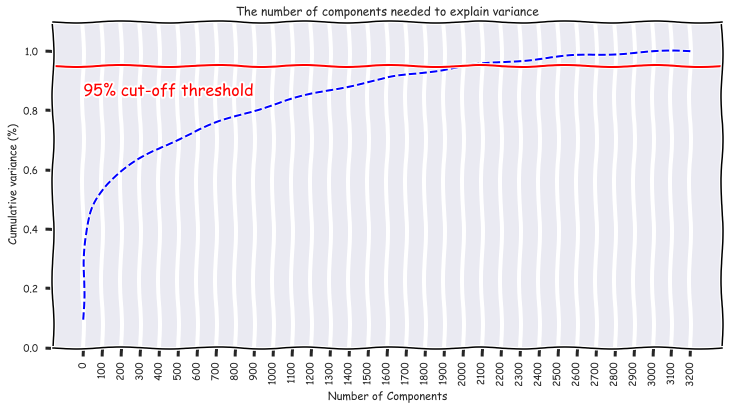

In [22]:
find_pca_threshold(X_train)

Let's find out which model works best.

In [23]:
model_evaluation(X_train, y_train, X_test, y_test, n_components=2100)

XGBClassifier pipeline test accuracy: 0.754
XGBClassifier pipeline train accuracy: 0.926
--------------------------------------------------------------------------------------
Random Forest pipeline test accuracy: 0.723
Random Forest pipeline train accuracy: 1.000
--------------------------------------------------------------------------------------
Support Vector Machine pipeline test accuracy: 0.780
Support Vector Machine pipeline train accuracy: 0.947
--------------------------------------------------------------------------------------
AdaBoost Classifier pipeline test accuracy: 0.727
AdaBoost Classifier pipeline train accuracy: 0.813
--------------------------------------------------------------------------------------
KNeighborsClassifier pipeline test accuracy: 0.723
KNeighborsClassifier pipeline train accuracy: 0.821
--------------------------------------------------------------------------------------


Support Vector Machine seems to be the best choice here. However XGBClassifier and Random forest performed farely well too. I am going to pick these three for Grid search.

## 4. Grid Search

In order to make my data suitable for modelling I will use Standard Scaler to scale budget and run_time data and then one hot encode all categorical variables. Then I will set PCA to explain 90% of variance.

In [24]:
preprocessor = make_column_transformer((StandardScaler(), ['budget', 'run_time']), 
                                           remainder=OneHotEncoder(handle_unknown='ignore', sparse=False))
#set up pipelines for gridsearch
xgb_pipe = Pipeline([('preprocessor', preprocessor),
                         ('pca', PCA(n_components=0.9)),
                         ('clf', XGBClassifier())])

rf_pipe = Pipeline([('preprocessor', preprocessor),
                        ('pca', PCA(n_components=0.9)),
                        ('clf', RandomForestClassifier())])

svm_pipe = Pipeline([('preprocessor', preprocessor),
                         ('pca', PCA(n_components=0.9)),
                         ('clf', svm.SVC())])

In [264]:
models = {
    'XGBClassifier':xgb_pipe,
    'RandomForestClassifier': rf_pipe,
    'SupportVectorMachine': svm_pipe
}


params = {
    'XGBClassifier': {
    'clf__colsample_bytree':[0.8],
    'clf__gamma':[0.7],
    'clf__max_depth': [4, 6, 9],
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [100, 250, 500],
    'clf__min_child_weight': [3, 6, 9],
    'clf__subsample': [0.8]
},
    'RandomForestClassifier': {
    'clf__max_features': ['auto'],
    'clf__n_estimators': [100, 250, 500],
    'clf__criterion': ['entropy', 'gini'], 
    'clf__max_depth': [4, 6, 9],  
    'clf__min_samples_leaf':[0.1, 0.2],  
    'clf__min_samples_split':[0.1, 0.2]
},
    
    'SupportVectorMachine': [{'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [10, 1, 0.1, 0.01], 'clf__kernel': ['sigmoid']},
                            {'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [10, 1, 0.1, 0.01], 'clf__kernel': ['rbf']},
                            {'clf__C': [0.1, 1, 10, 100,], 'clf__gamma': [10, 1, 0.1, 0.01], 'clf__degree': [3,4,5], 'clf__kernel': ['poly']}]
    
}

In [265]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_train, y_train, scoring='accuracy', n_jobs=-1)

Running GridSearchCV for XGBClassifier.
Running GridSearchCV for RandomForestClassifier.
Running GridSearchCV for SupportVectorMachine.
Done.


In [266]:
summary = helper.score_summary()
summary.head(20)

,estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,SupportVectorMachine,"{'clf__C': 100, 'clf__gamma': 0.1, 'clf__kerne...",0.780741,0.802671,0.781899,0.786350,0.790801,0.788492
1,SupportVectorMachine,"{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel...",0.780741,0.802671,0.777448,0.786350,0.792285,0.787899
2,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.788148,0.814540,0.775964,0.774481,0.777448,0.786116
3,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.782222,0.802671,0.783383,0.781899,0.768546,0.783744
4,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.771852,0.818991,0.780415,0.771513,0.767062,0.781967
5,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.788148,0.808605,0.770030,0.770030,0.772997,0.781962
6,SupportVectorMachine,"{'clf__C': 100, 'clf__gamma': 0.01, 'clf__kern...",0.768889,0.787834,0.770030,0.784866,0.793769,0.781077
7,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.786667,0.799703,0.787834,0.765579,0.765579,0.781072
8,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.765926,0.820475,0.778932,0.770030,0.764095,0.779891
9,XGBClassifier,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0...",0.768889,0.807122,0.772997,0.770030,0.774481,0.778704


In [267]:
print(summary['params'][0])
print(summary['params'][1])
print(summary['params'][2])
print(summary['params'][21])

{'clf__C': 100, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0.7, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__min_child_weight': 9, 'clf__n_estimators': 250, 'clf__subsample': 0.8}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0.7, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 6, 'clf__n_estimators': 250, 'clf__subsample': 0.8}


Now let's run our model with tuned parameters. In order to evaluate model's performance I am going to use Accuracy score and classification report.

In [25]:
svm_best = Pipeline([('preprocessor', preprocessor),
                         ('pca', PCA(n_components=0.9)),
                         ('clf', svm.SVC(C=100, gamma=0.1, kernel='rbf'))])

test_accuracy(svm_best, X_train, y_train, X_test, y_test)
                     

Training Accuracy: 99.97%
Validation accuracy: 79.63%
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1093
           1       0.75      0.52      0.61       488

    accuracy                           0.80      1581
   macro avg       0.78      0.72      0.74      1581
weighted avg       0.79      0.80      0.78      1581



Tuned parameters increased accuracy by almost 1%. That is a very good result.

### 5. Predictions for best crew

Let's see how model will behave when I test it against best cast and crew

I am going check what kind of movies make most money and what cast and crew influence movie profit the most.

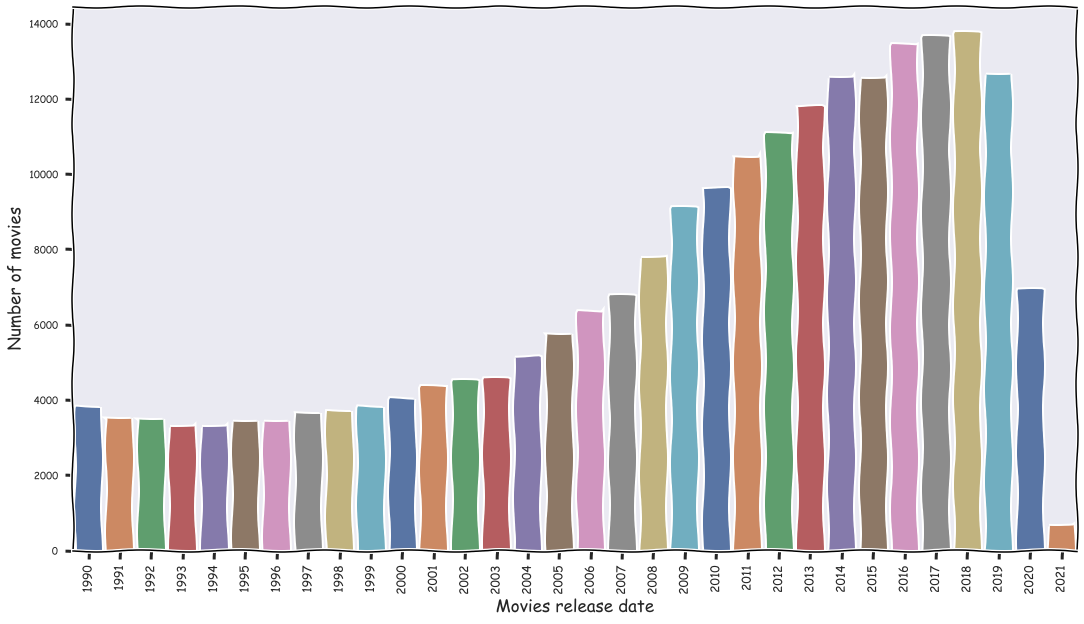

In [26]:
plt.figure(figsize = (18,10))
sns.countplot(df.year, palette=current_palette)
plt.xticks(rotation= 90,fontsize = 12)
plt.xlabel("Movies release date",fontsize =17)
plt.ylabel("Number of movies",fontsize = 17)
plt.show()

Plot above shows that most movies were made in the last decade. There are a lot of new productions. I am looking for crew members that consistenly make movies profitable.

First I will prepare my data for visualization then I will you my functions to see what actors and directors bring most profit

In [27]:
df_plot = df.copy()
df_plot.dropna(subset=['worldwide', 'budget'], inplace=True)
df_plot.year = df_plot.year.astype('int64')
df_plot.budget = df_plot.budget.astype('int64')
df_plot['Main Actor'] = df_plot['main_actor_1']#rename columns to make it look better on plot
df_plot['Running time'] = df_plot['run_time'] 
df_plot['Release date'] = df_plot['release_date']
df_plot['Genre'] = df_plot['genre_1'] + "-" + df_plot['genre_2']
df_plot['profit'] = df_plot['worldwide'] - df_plot['budget']
df_plot.drop(['run_time', 'release_date', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'main_actor_2', 'main_actor_3',
       'main_actor_4'], axis=1, inplace=True)

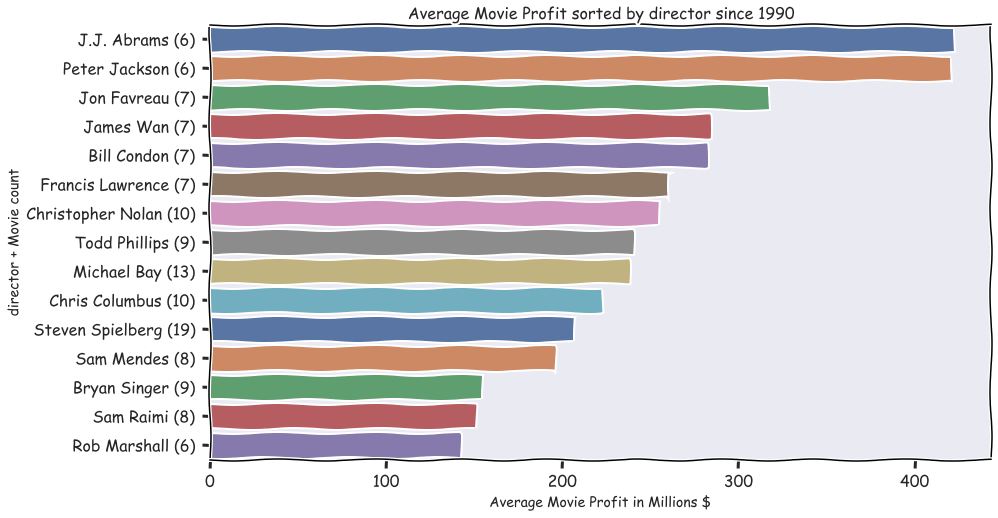

In [28]:
#average movie profit for directors that worked on at least 5 movies
directors = plot_by_profit(df_plot, 'director', 1990, 5)

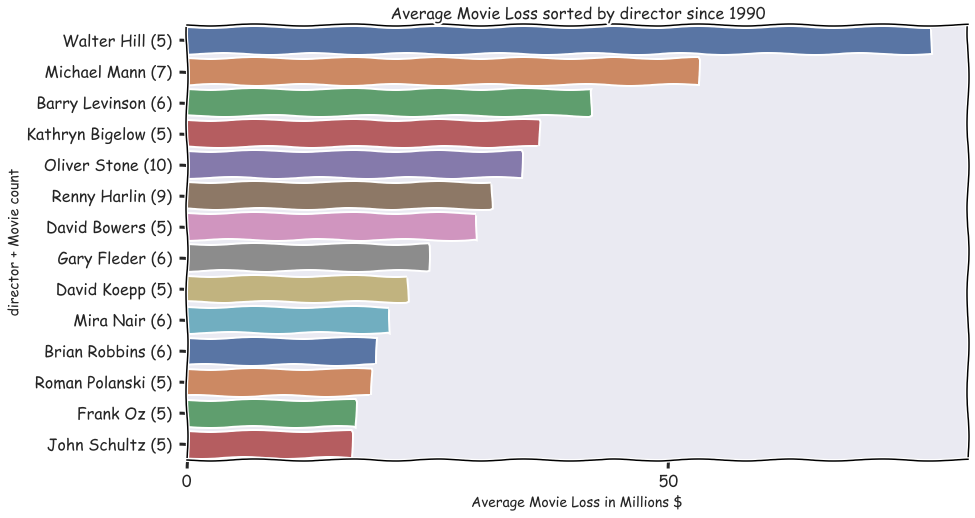

In [29]:
#worst directors that directed at least 4 movies
directors_worst = plot_by_profit(df_plot, 'director', 1990, 4, sort_by_worst=True)

In [30]:
#Store best directors for final test
director_list = [x.split('(') for x in directors['director+count']]
director_list = [x[0].strip() for x in director_list][:15]

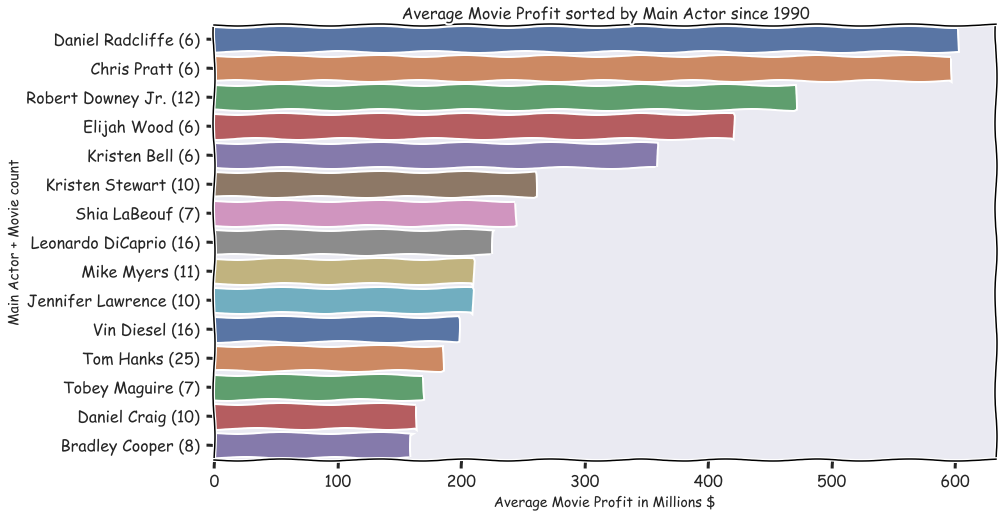

In [31]:
#Best actors that starred in at least 5 movies
actors = plot_by_profit(df_plot, 'Main Actor', 1990, 5)

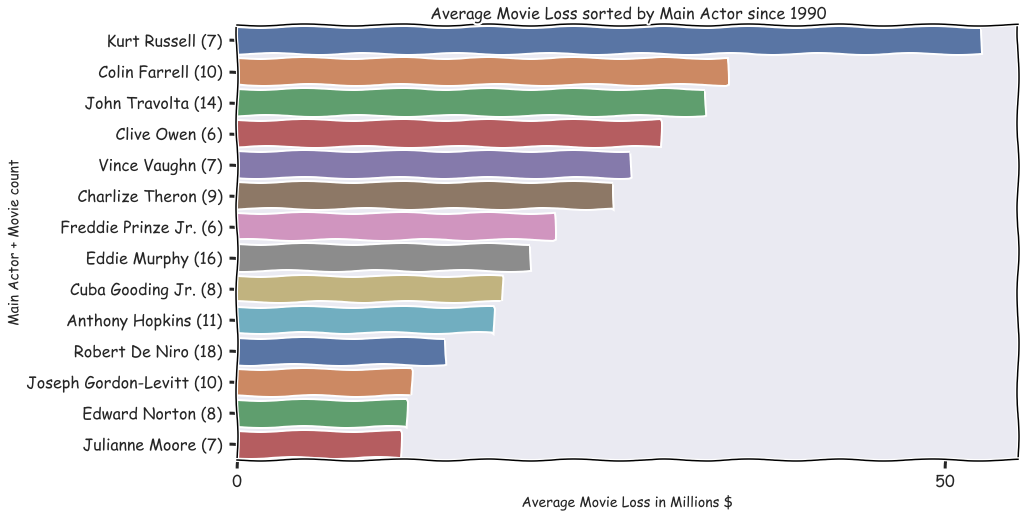

In [32]:
#worst actors that starred in at least 5 movies
actors_worst = plot_by_profit(df_plot, 'Main Actor', 1990, 5, True)

In [33]:
#store best actors for final test
actor_list = [x.split('(') for x in actors['Main Actor+count']]
actor_list = [x[0].strip() for x in actor_list][:15]

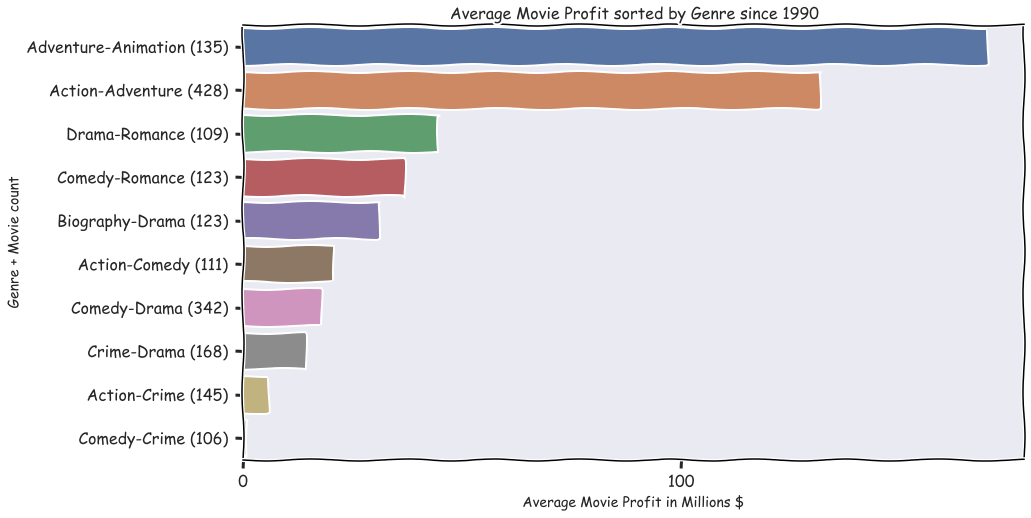

In [34]:
genres = plot_by_profit(df_plot, 'Genre', 1990, 100)

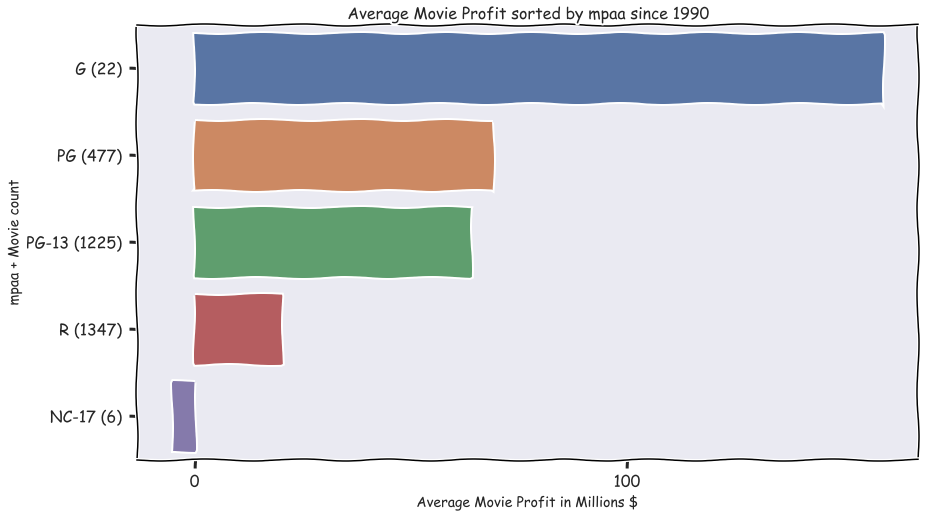

,mpaa+count,profit
0,G (22),1.591540e+08
2,PG (477),6.910035e+07
3,PG-13 (1225),6.387854e+07
4,R (1347),2.012939e+07
1,NC-17 (6),-5.090206e+06


In [35]:
plot_by_profit(df_plot, 'mpaa', 1990)

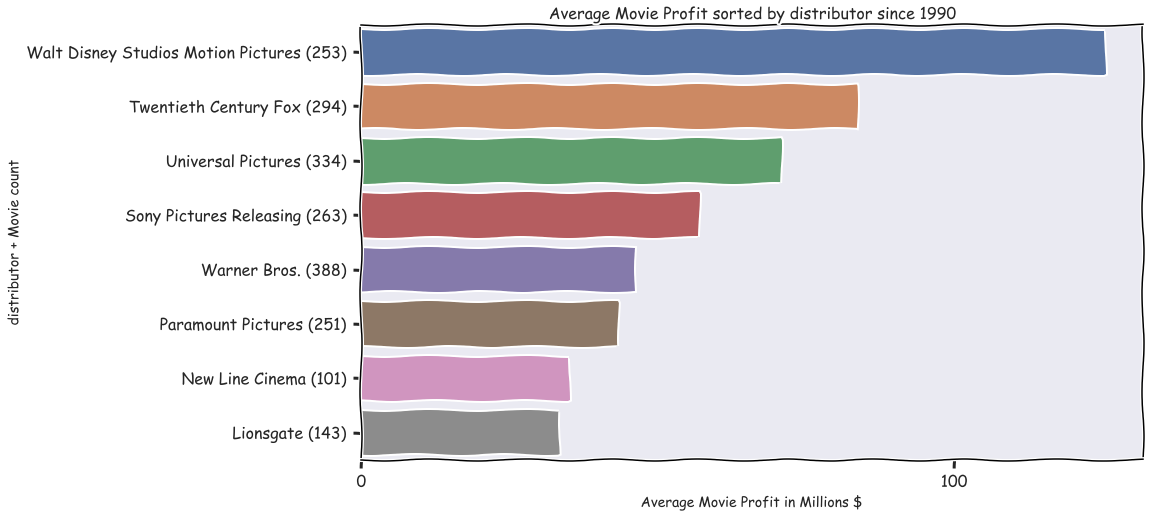

In [36]:
distributor = plot_by_profit(df_plot, 'distributor', 1990, 100)

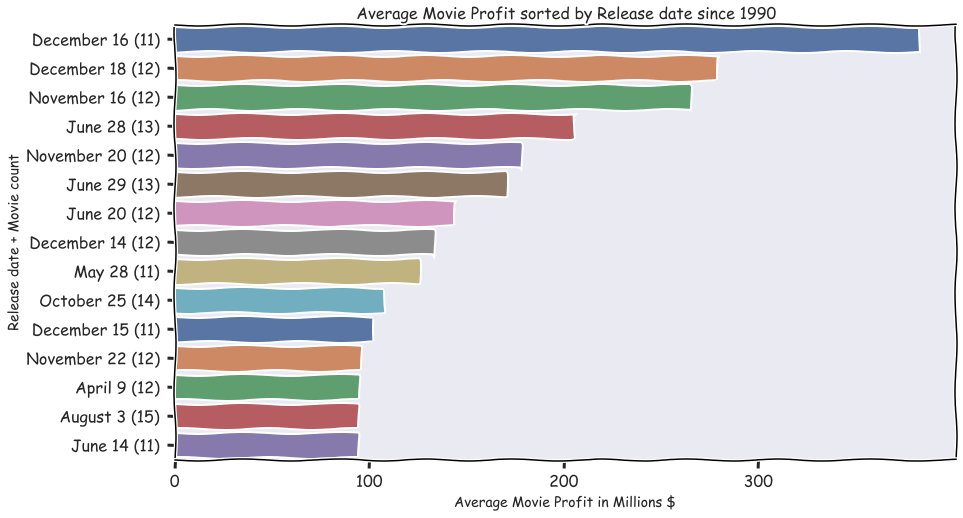

In [50]:
release_dates = plot_by_profit(df_plot, 'Release date', 1990, 10)

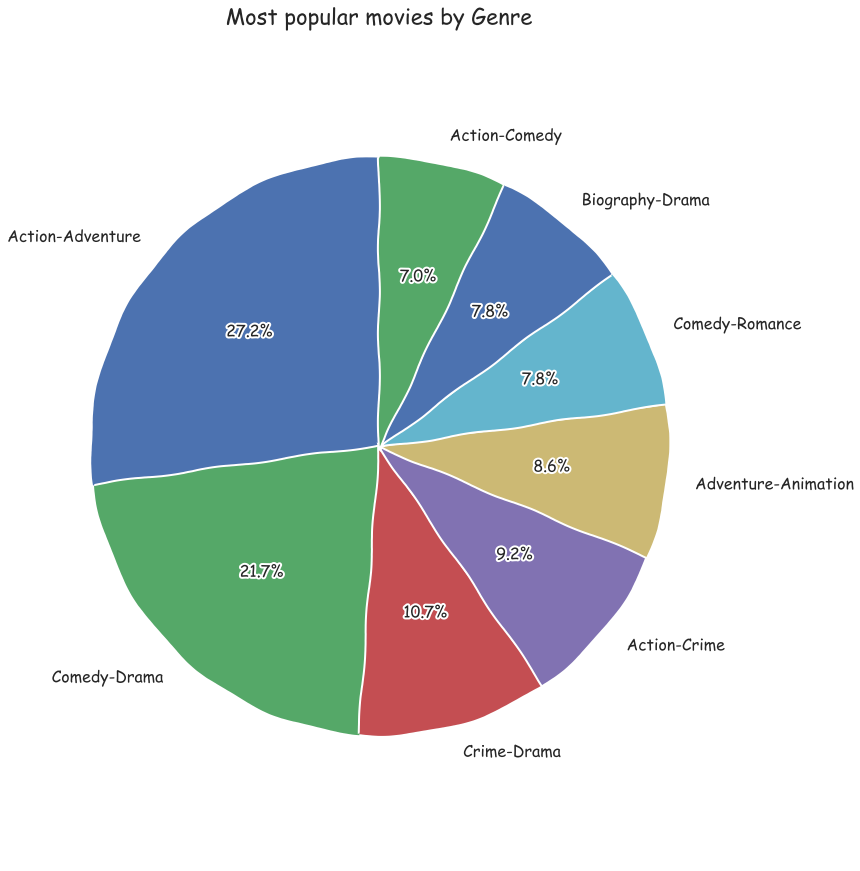

In [37]:
pie_by_value(df_plot, 'Genre', 8)

Filter test dataset for most profitable crew

In [38]:
X_test['successful'] = y_test
directors = X_test[X_test.director.isin(director_list)]
actors = X_test[X_test.main_actor_1.isin(actor_list)]
best_crew = pd.concat([directors, actors])
best_crew = best_crew[~best_crew['mpaa'].isin(['NC-17', 'R'])]
best_crew = best_crew[best_crew['genre_1'].isin(['Action', 'Comedy', 'Adventure', 'Animation'])]

In [39]:
false = best_crew[best_crew.successful == 0]
true = best_crew[best_crew.successful == 1]
print('Successful', np.round(100 * (len(true) / len(best_crew))), '%')
print('Unsuccessful', np.round(100 * (len(false) / len(best_crew))), '%')

Successful 85.0 %
Unsuccessful 15.0 %


In [40]:
X_test = best_crew.drop('successful', axis=1)
y_test = best_crew['successful']
test_accuracy(svm_best, X_train, y_train, X_test, y_test)

Training Accuracy: 99.97%
Validation accuracy: 83.33%
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.92      0.88      0.90        51

    accuracy                           0.83        60
   macro avg       0.69      0.72      0.70        60
weighted avg       0.85      0.83      0.84        60



Looks like this time it was a bit hard for the model to tell if movie is going to fail. Overall it showed good results.

## Predict movies for this year

In [41]:
df_future = df[df['year'] >= 2020]
to_drop = ['movie_id', 'trivia', 'year', 'writer', 'main_actor_3', 
           'main_actor_4', 'genre_3', 'genre_4', 'domestic', 'international', 'worldwide', 'html']

clean_data(df_future, to_drop)

In [42]:
titles = df_future['title']
df_future.drop(['title'], axis=1, inplace=True)
df_future['successful'] = svm_best.predict(df_future)
predictions = pd.concat([titles, df_future], axis=1)

In [56]:
predictions.drop(['producer', 'composer', 'run_time', 'distributor'], axis=1)

,title,mpaa,release_date,director,cinematographer,main_actor_1,main_actor_2,budget,genre_1,genre_2,successful
59522,Fantasy Island,PG-13,February,Jeff Wadlow,Toby Oliver,Michael Peña,Maggie Q,7000000.0,Adventure,Fantasy,1
65719,The Invisible Man,R,February,Leigh Whannell,Stefan Duscio,Elisabeth Moss,Oliver Jackson-Cohen,7000000.0,Horror,Mystery,1
68613,Sarileru Neekevvaru,PG-13,January,Anil Ravipudi,R. Rathnavelu,Mahesh Babu,Rashmika Mandanna,30000000.0,Action,Comedy,0
69543,Bill & Ted Face the Music,PG-13,August,Dean Parisot,Shelly Johnson,Keanu Reeves,Alex Winter,30000000.0,Comedy,Music,0
93356,Bad Boys for Life,R,January,Adil El Arbi,Robrecht Heyvaert,Will Smith,Martin Lawrence,90000000.0,Action,Comedy,0
99493,Bloodshot,PG-13,March,Dave Wilson,Jacques Jouffret,Vin Diesel,Eiza González,45000000.0,Action,Drama,0
107927,Honest Thief,PG-13,September,Mark Williams,Shelly Johnson,Liam Neeson,Kate Walsh,30000000.0,Action,Crime,0
122536,What About Love,PG-13,September,Klaus Menzel,Reinhart 'Rayteam' Peschke,Sharon Stone,Andy Garcia,30000000.0,Drama,Romance,0
126845,No Time to Die,PG-13,November,Cary Joji Fukunaga,Linus Sandgren,Ana de Armas,Daniel Craig,30000000.0,Action,Adventure,1
128218,Wendy,PG-13,February,Benh Zeitlin,Sturla Brandth Grøvlen,Yashua Mack,Devin France,30000000.0,Drama,Fantasy,0


## Conclusion

**Is it possible to predict movie success or failure based on budget, genre, cast and crew information?**

The test results show that it is possible with 80% accuracy.

**What can be done to increase accurasy?**
- Train model on more data. 
- Possibly use pseudolabeling. 
- Run Gridsearch with more hyperparameters.